In [1]:
import pandas as pd
train_features = pd.read_csv('https://drive.google.com/uc?export=download&id=14ULvX0uOgftTB2s97uS8lIx1nHGQIB0P')
train_labels = pd.read_csv('https://drive.google.com/uc?export=download&id=1r441wLr7gKGHGLyPpKauvCuUOU556S2f')
test_features = pd.read_csv('https://drive.google.com/uc?export=download&id=1wvsYl9hbRbZuIuoaLWCsW_kbcxCdocHz')
sample_submission = pd.read_csv('https://drive.google.com/uc?export=download&id=1kfJewnmhowpUo381oSn3XqsQ6Eto23XV')
train_features.shape, train_labels.shape, test_features.shape, sample_submission.shape

((59400, 40), (59400, 2), (14358, 40), (14358, 2))

In [44]:
train_features.head()


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [45]:
train_features['num_private'].unique()

array([   0,   39,    5,   45,    6,    3,  698,   32,   15,    7,   25,
        102,    1,   93,   14,   34,  120,   17,  213,   47,    8,   41,
         80,  141,   20,   35,  131,    4,   22,   11,   87,   61,   65,
        136,    2,  180,   38,   62,    9,   16,   23,   42,   24,   12,
        668,  672,   58,  150,  280,  160,   50, 1776,   30,   27,   10,
         94,   26,  450,  240,  755,   60,  111,  300,   55, 1402])

In [3]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [4]:
#Split Train/Test
from sklearn.model_selection import train_test_split

X_train = train_features
y_train = train_labels['status_group']

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size=0.80, test_size=0.20, 
    stratify=y_train, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((47520, 40), (11880, 40), (47520,), (11880,))

In [56]:
#Cardinality Check
X_train.describe(exclude='number').T.sort_values(by='unique').head(15)

,count,unique,top,freq
recorded_by,47520,1,GeoData Consultants Ltd,47520
public_meeting,44876,2,True,40838
permit,45077,2,True,31071
source_class,47520,3,groundwater,36638
management_group,47520,5,user-group,42027
quantity_group,47520,5,enough,26567
quantity,47520,5,enough,26567
waterpoint_type_group,47520,6,communal standpipe,27642
quality_group,47520,6,good,40598
payment_type,47520,7,never pay,20287


In [21]:
#encode 'quality' as with the lecture
from sklearn.linear_model import LogisticRegression
import category_encoders as ce
X_train['quantity'].value_counts(dropna=False)

enough          26567
insufficient    12153
dry              4921
seasonal         3244
unknown           635
Name: quantity, dtype: int64

In [28]:
# Recombine X_train and y_train, for exploratory data analysis

def check_categorical(features_df, labels, cat_feat, target = 'status_group'):
    train = features_df.copy()
    train[target] = labels

    # Now do groupby...
    return train.groupby(cat_feat)[target].value_counts(normalize=True)
X_train.head()
check_categorical(X_train, y_train, 'quantity')


quantity      status_group           
dry           non functional             0.967689
              functional                 0.026011
              functional needs repair    0.006300
enough        functional                 0.650920
              non functional             0.276998
              functional needs repair    0.072082
insufficient  functional                 0.521106
              non functional             0.382786
              functional needs repair    0.096108
seasonal      functional                 0.580456
              non functional             0.318434
              functional needs repair    0.101110
unknown       non functional             0.713386
              functional                 0.267717
              functional needs repair    0.018898
Name: status_group, dtype: float64

In [61]:
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(X_train['quantity'])
encoded.head(10)

,quantity_insufficient,quantity_enough,quantity_dry,quantity_seasonal,quantity_unknown
43360,1,0,0,0,0
7263,0,1,0,0,0
2486,1,0,0,0,0
313,0,1,0,0,0
52726,0,1,0,0,0
8558,1,0,0,0,0
2559,1,0,0,0,0
54735,0,1,0,0,0
25763,0,1,0,0,0
44540,0,1,0,0,0


In [13]:
from sklearn.preprocessing import StandardScaler

categorical_features = ['quantity']
numeric_features = X_train.select_dtypes('number').columns.drop('id').tolist()
features = categorical_features + numeric_features

X_train_subset = X_train[features]
X_val_subset = X_val[features]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train_subset)
X_val_encoded = encoder.transform(X_val_subset)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

/home/richmond/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/richmond/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/richmond/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


Validation Accuracy 0.6579124579124579


['quantity', 'quality_group']

In [60]:
check_categorical(X_train, y_train,  'source_class')


source_class  status_group           
groundwater   functional                 0.541460
              non functional             0.398575
              functional needs repair    0.059965
surface       functional                 0.548554
              non functional             0.333866
              functional needs repair    0.117581
unknown       functional                 0.547009
              non functional             0.431624
              functional needs repair    0.021368
Name: status_group, dtype: float64

In [57]:
check_categorical(X_train, y_train, 'water_quality')


water_quality       status_group           
coloured            functional                 0.496278
                    non functional             0.394541
                    functional needs repair    0.109181
fluoride            functional                 0.769697
                    non functional             0.175758
                    functional needs repair    0.054545
fluoride abandoned  non functional             0.642857
                    functional                 0.357143
milky               functional                 0.550152
                    non functional             0.433131
                    functional needs repair    0.016717
salty               non functional             0.500128
                    functional                 0.452472
                    functional needs repair    0.047399
salty abandoned     functional                 0.514493
                    non functional             0.278986
                    functional needs repair    0.206522
soft

In [58]:
#add Features
from sklearn.preprocessing import StandardScaler

categorical_features = ['quantity', 'water_quality' ,'public_meeting', '']
numeric_features = X_train.select_dtypes('number').columns.drop('id').drop('district_code').tolist()
features = categorical_features + numeric_features

X_train_subset = X_train[features]
X_val_subset = X_val[features]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train_subset)
X_val_encoded = encoder.transform(X_val_subset)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

/home/richmond/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/richmond/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/richmond/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


Validation Accuracy 0.6595959595959596


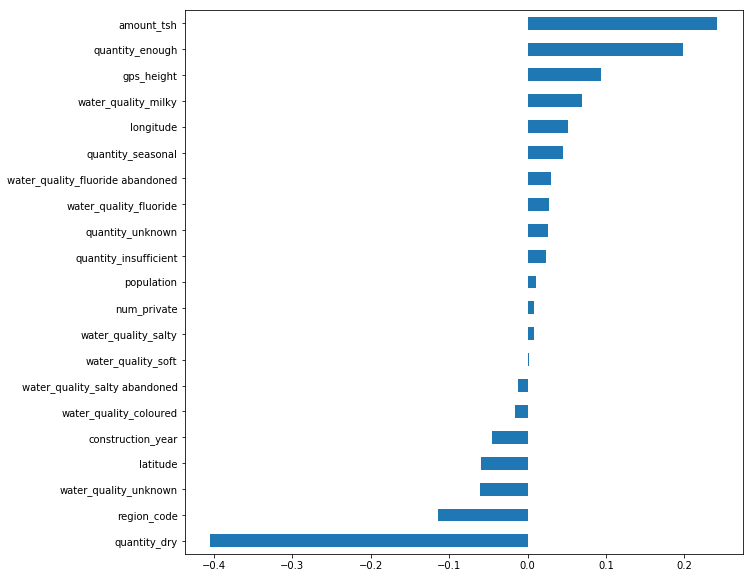

In [62]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
coefficients.sort_values().plot.barh();